In [4]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

import covid
import covid.util as util
from covid.models.SEIRD import SEIRD_stochastic

# Load Data and Set Parameters

In [33]:
data = util.load_state_data()
place = 'NY'
start = '2020-03-04'
end = '2020-04-01'
save = True
num_warmup = 100
num_samples = 100
num_chains = 1
num_prior_samples = 100
T_future = 30

confirmed = data[place]['data'].confirmed[start:end]
death = data[place]['data'].death[start:end]

In [34]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = state_data

In [41]:
import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive

import covid.models.SEIRD

T = len(confirmed)
N = data[place]['pop']


prob_model = covid.models.SEIRD.SEIRD_stochastic


args = {
    'N': N,
    'T': T,
    'rw_scale': 2e-1
}

kernel = NUTS(prob_model,
              init_strategy = numpyro.infer.util.init_to_median())

mcmc = MCMC(kernel, 
            num_warmup=num_warmup, 
            num_samples=num_samples, 
            num_chains=num_chains)

print(f"{place}")
print(" * run MCMC")
mcmc.run(jax.random.PRNGKey(2),
         obs = confirmed.values,
         death = death.values,
         **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

# Prior samples
print(" * collect prior samples")
prior = Predictive(prob_model, posterior_samples = {}, num_samples = num_prior_samples)
prior_samples = prior(PRNGKey(2), **args)

# In-sample posterior predictive samples (don't condition on observations)
print(" * collect predictive samples")
post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), **args)

# Forecasting posterior predictive (do condition on observations)
print(" * collect forecast samples")
forecast_samples = post_pred(PRNGKey(2), 
                             obs = confirmed.values,
                             death = death.values,
                             T_future=T_future, 
                             **args)

NY
 * run MCMC


sample: 100%|██████████| 200/200 [00:40<00:00,  4.89it/s, 511 steps of size 8.68e-03. acc. prob=0.95] 



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          D0      0.08      0.08      0.06      0.01      0.21    108.07      0.99
          E0    175.07    113.00    154.43     26.59    322.89     61.63      0.99
          H0      0.33      0.33      0.23      0.00      0.80    127.83      0.99
          I0     35.54     11.61     33.73     20.98     57.96     90.54      0.99
     beta[0]      1.65      0.70      1.51      0.58      2.55     66.32      1.00
     beta[1]      1.66      0.71      1.48      0.64      2.71     80.48      0.99
     beta[2]      1.69      0.76      1.49      0.85      2.95     87.11      0.99
     beta[3]      1.69      0.74      1.49      0.79      2.79     99.98      0.99
     beta[4]      1.79      0.75      1.57      0.98      2.79     75.30      0.99
     beta[5]      2.03      0.97      1.75      0.81      2.97     68.21      0.99
     beta[6]      2.44      1.30      2.09      1.17      3.60     65.46      0.99
   

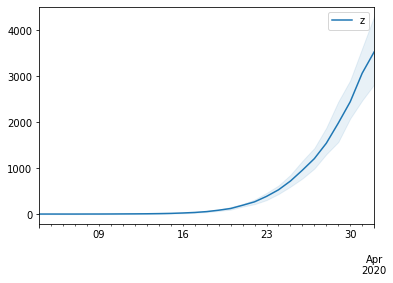

In [52]:
place = 'NY'
start = '2020-03-04'
end = '2020-04-01'
T_future = 30
legend=True
ax = None
plot_fields = ['z']

confirmed = data[place]['data'].confirmed[start:end]
death = data[place]['data'].death[start:end]

# Plot posterior predictive
util.plot_samples()

# Add prediction intervals
pi_max = 10
i = 0
for i, pi in enumerate(pred_intervals.values()):
    ax.fill_between(t, pi[0,:], pi[1,:], color=colors[i], alpha=0.1, label='CI')
    pi_max = np.maximum(pi_max, np.nanmax(pred_interval[1,:]))


# Plot forecast predictive

# Plot all observations

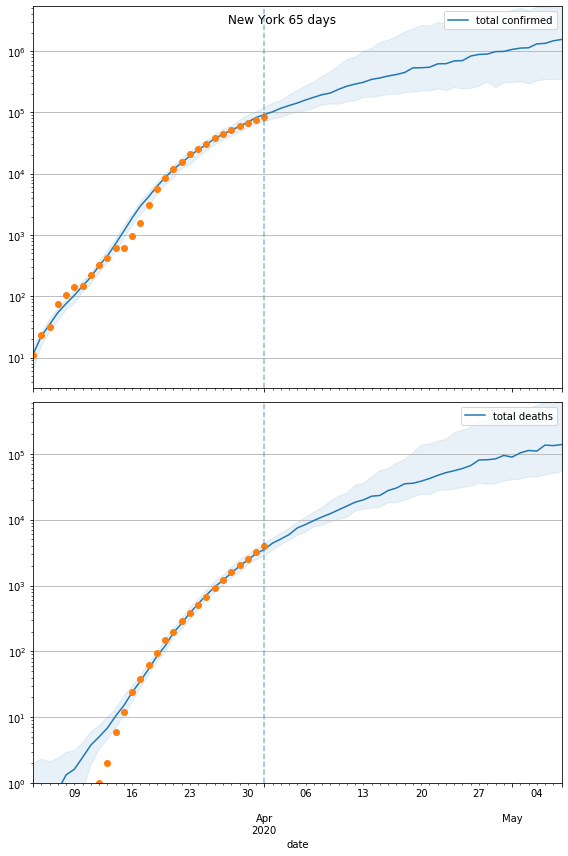

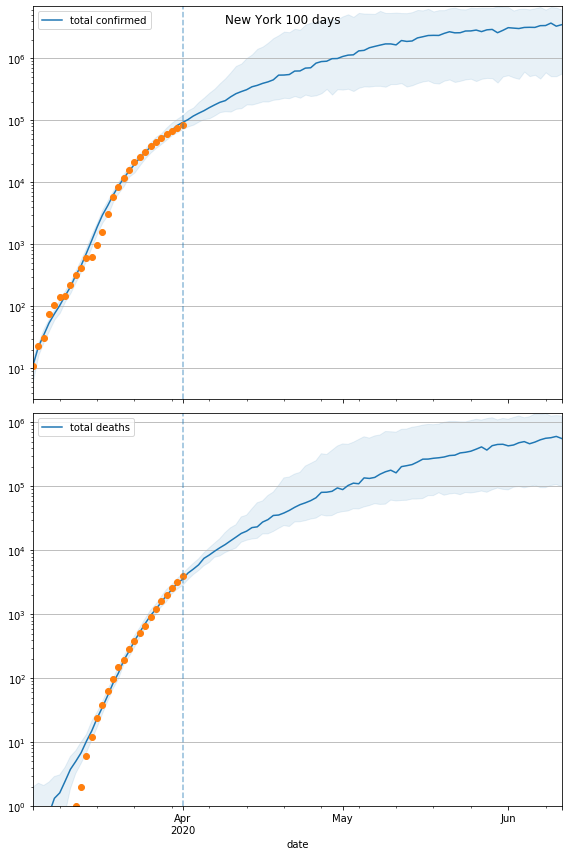

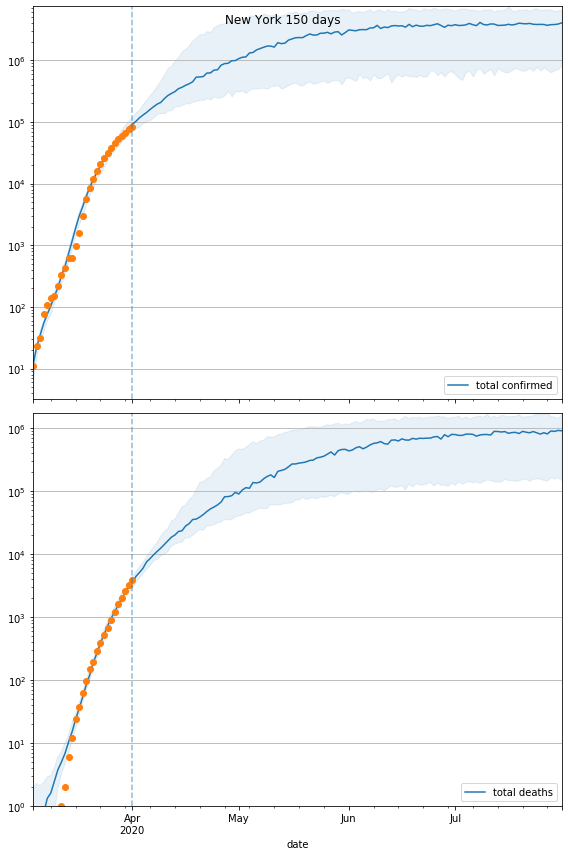

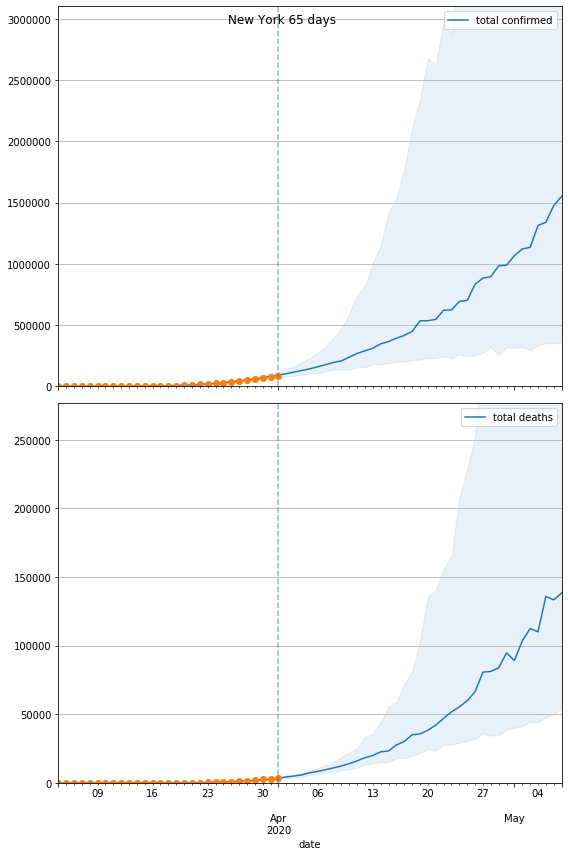

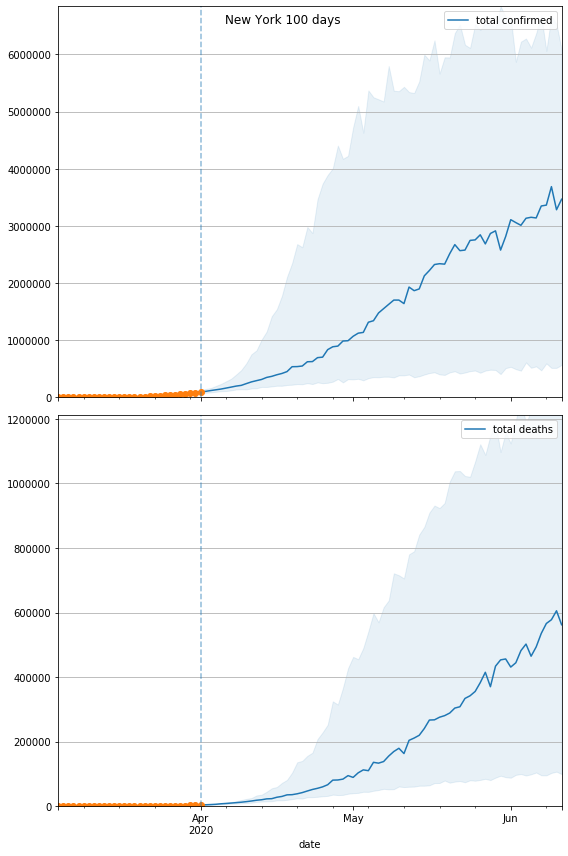

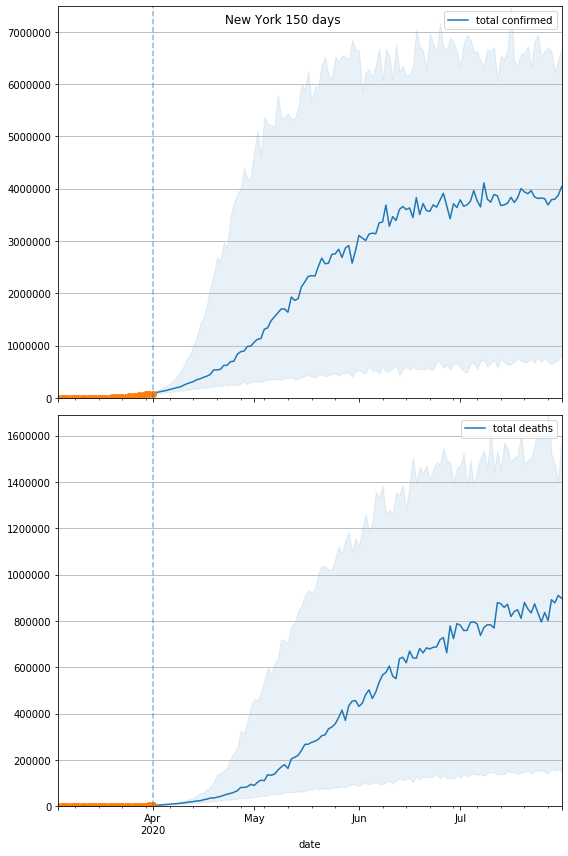

<Figure size 360x216 with 0 Axes>

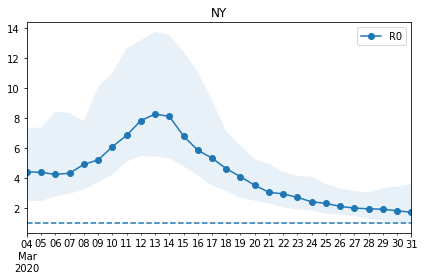

In [11]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = state_data



place = 'NY'

# train start and end
start = '2020-03-04'
end = '2020-04-01'

save = True

# Inspect and Save Results 
util.gen_forecasts(data, 
                   place, 
                   start=start,
                   end=end,
                   save=save, 
                   daily=False)
